In [1]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

# 2. Data preprocessing

## 2.1. Available features

The [Lending Club dataset provided by Wendy Kan from Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data) doesn't contain some of the features that are available for investors like, for example, FICO scores. Therefore, I use the [Lending Club dataset provided by Nathan George](https://www.kaggle.com/wordsforthewise/lending-club) that has all Lending Club loan features. This dataset contains more than 2 million rows so to reduce the processing times, I only selected the loans issued in 2018 (≈0.5 million rows).

In [2]:
data = pd.read_csv(
    '../data/raw/accepted_2007_to_2018Q4.csv',
    parse_dates=['issue_d'], infer_datetime_format=True)
data = data.reset_index(drop=True)
data.head()

d:\Users\Michal\Documents\Studia\semestr2\NLP\nlp\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
X = data[data['loan_status'] != 'Current'].copy()
X.loc[X['loan_status'] == 'Fully Paid', 'target'] = 0
X.loc[X['loan_status'] != 'Fully Paid', 'target'] = 1
X = X.drop(columns=['id', 'loan_status'])

In [22]:
X.target.value_counts()

0.0    1076751
1.0     305633
Name: target, dtype: int64

## 2.2. Feature types

Let's check the categorical features and see if any of them could be transformed to other types.

In [23]:
X.select_dtypes('object').head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,pymnt_plan,url,desc,...,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date
0,36 months,C,C4,leadman,10+ years,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
1,36 months,C,C1,Engineer,10+ years,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
2,60 months,B,B4,truck driver,10+ years,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
4,60 months,F,F1,Contract Specialist,3 years,MORTGAGE,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
5,36 months,C,C3,Veterinary Tecnician,4 years,RENT,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN


The features `earliest_cr_line` and `sec_app_earliest_cr_line` are dates and their type should be changed to `datetime`. Later they will be transformed to ordinal numeric features by the machine learning model.

In [24]:
X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
X['last_credit_pull_d'] = pd.to_datetime(X['last_credit_pull_d'], infer_datetime_format=True)
X['last_pymnt_d'] = pd.to_datetime(X['last_pymnt_d'], infer_datetime_format=True)
X['sec_app_earliest_cr_line'] = pd.to_datetime(X['sec_app_earliest_cr_line'], infer_datetime_format=True)

The features `emp_length` and `id` are numeric and their type should be changed to `float`. In case of `emp_length` I replace the extreme cases of "< 1 year" and "10+ years" with "0 years" and "11 years" respectively to separate these groups from the rest.

In [25]:
X['emp_length'] = X['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
X['emp_length'] = X['emp_length'].str.extract('(\d+)').astype('float')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
        X.drop(columns=['target']), X['target'], test_size=0.2, stratify=X['target'],
        random_state=42
    )
X_train['target'] = y_train
X_test['target'] = y_test

## 2.3. Missing values

Although the machine learning model used here can deal with missing values, it is a good practice to do it yourself or ideally with a domain expert. Below is the table of columns with missing values and their ratio to the total number of rows.

In [27]:
nan_mean = X_train.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean[nan_mean > 0.9]

desc                                          0.908937
next_pymnt_d                                  0.973148
debt_settlement_flag_date                     0.975247
settlement_date                               0.975247
settlement_amount                             0.975247
settlement_status                             0.975247
settlement_term                               0.975247
settlement_percentage                         0.975247
annual_inc_joint                              0.978502
dti_joint                                     0.978505
verification_status_joint                     0.978690
sec_app_inq_last_6mths                        0.983896
sec_app_fico_range_low                        0.983896
sec_app_earliest_cr_line                      0.983896
sec_app_fico_range_high                       0.983896
sec_app_chargeoff_within_12_mths              0.983896
sec_app_num_rev_accts                         0.983896
sec_app_open_act_il                           0.983896
sec_app_op

The features `desc` and `member_id` are completely empty so I remove them.

In [28]:
X_train = X_train.drop(nan_mean[nan_mean > 0.9].keys(), axis=1, errors='ignore')
X_test = X_test.drop(nan_mean[nan_mean > 0.9].keys(), axis=1, errors='ignore')

For categorical features `emp_title`, `verification_status_joint` the missing values should be filled with an empty string so these features are placed in the list `fill_empty`.

For some of the numeric features the missing values should be filled using the maximum value of the respective columns so these features are placed in the list `fill_max`. For example, the feature `mths_since_last_record` indicates the number of months since the last record (like bankruptcy, foreclosure, tax liens, etc.) so if missing, one should assume that no records were made and the number of months since the "last" record should be a maximum.

For the rest of the numeric features the missing values should be filled using the minimum value of the respective columns so these features are placed in the list `fill_min`. For example, the feature `emp_length` indicates the number of working years so if missing, one should assume that the borrower never worked and the number of working years should be a minimum.

In [33]:
fill_empty = ['emp_title']
fill_max = ['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq']
fill_min = np.setdiff1d(X_train.columns.values, np.append(fill_empty, fill_max))

X_train[fill_empty] = X_train[fill_empty].fillna('')
X_test[fill_empty] = X_test[fill_empty].fillna('')
X_train[fill_max] = X_train[fill_max].fillna(X_train[fill_max].max(numeric_only=True))
X_test[fill_max] = X_test[fill_max].fillna(X_train[fill_max].max(numeric_only=True))
X_train[fill_min] = X_train[fill_min].fillna(X_train[fill_min].min(numeric_only=True))
X_test[fill_min] = X_test[fill_min].fillna(X_train[fill_min].min(numeric_only=True))

## 2.3. Multicollinearity

Although highly correlated features (*multicollinearity*) aren't a problem for the machine learning models based on decision trees (as used here), these features decrease importances of each other and can make feature analysis more difficult. Therefore, I calculate feature correlations and remove the features with very high correlation coefficients before applying machine learning.

I start with numeric features and before calculating their correlations, it's a good practice to look at the number of their unique values.

In [34]:
X_train.shape

(1105907, 111)

In [35]:
num_feat = X_train.select_dtypes('number').columns.values
X_train[num_feat].nunique().sort_values()

policy_code               1
target                    2
num_tl_30dpd              5
num_tl_120dpd_2m          6
acc_now_delinq            8
                     ...   
tot_hi_cred_lim      392216
total_rec_int        475261
last_pymnt_amnt      590210
total_pymnt_inv      863846
total_pymnt         1041761
Length: 90, dtype: int64

In [36]:
X_train = X_train.drop(['policy_code'], axis=1, errors='ignore')
X_test = X_test.drop(['policy_code'], axis=1, errors='ignore')

For all pairs of the numeric features `comb_num_feat` I calculate their Pearson's R correlation coefficient and store it in `corr_num_feat`.

In [38]:
num_feat = X_train.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(X_train[comb[0]], X_train[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

The highly correlated pairs with the absolute value of their correlation coefficient ≥0.9 are printed below.

In [39]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['loan_amnt', 'funded_amnt'],
       ['loan_amnt', 'funded_amnt_inv'],
       ['loan_amnt', 'installment'],
       ['funded_amnt', 'funded_amnt_inv'],
       ['funded_amnt', 'installment'],
       ['funded_amnt_inv', 'installment'],
       ['fico_range_low', 'fico_range_high'],
       ['open_acc', 'num_sats'],
       ['out_prncp', 'out_prncp_inv'],
       ['total_pymnt', 'total_pymnt_inv'],
       ['total_pymnt', 'total_rec_prncp'],
       ['total_pymnt_inv', 'total_rec_prncp'],
       ['recoveries', 'collection_recovery_fee'],
       ['tot_cur_bal', 'tot_hi_cred_lim'],
       ['bc_open_to_buy', 'mths_since_recent_bc'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0']], dtype='<U30')

The first feature (chosen arbitrarily) from each highly correlated feature pair is then removed.

In [40]:
X_train = X_train.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')
X_test = X_test.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

Then I print out the number of unique values for categorical features.

In [41]:
cat_feat = X_train.select_dtypes('object').columns.values
X_train[cat_feat].nunique().sort_values()

term                          2
hardship_flag                 2
application_type              2
initial_list_status           2
disbursement_method           2
pymnt_plan                    2
debt_settlement_flag          2
verification_status           3
home_ownership                6
grade                         7
purpose                      14
sub_grade                    35
addr_state                   51
zip_code                    933
title                     52151
emp_title                322599
url                     1105880
dtype: int64

The feature `url` has a unique value for each entry and should be removed to avoid overfitting. The feature `emp_title` has very large number of unique values and leads to the memory error when creating a contingency table, therefore I remove it as well.

In [42]:
X_train = X_train.drop(['url', 'emp_title'], axis=1, errors='ignore')
X_test = X_test.drop(['url', 'emp_title'], axis=1, errors='ignore')

For all pairs of the categorical features `comb_cat_feat` I calculate the Cramer's V correlation coefficient that is expressed through the chi-square statistic $\chi^2$ of the contingency table:

$$ V = \sqrt{ \frac{ \chi^2 }{ n (\text{min}(K_1, K_2) - 1) } } $$

where $n$ is the sum of all elements in the contingency table, $K_1$ and $K_2$ are the dimensions of the contingency table. Note that Pearson's R correlation coefficient isn't applicable to categorical features and shouldn't be used.

In [43]:
cat_feat = X_train.select_dtypes('object').columns.values
comb_cat_feat = np.array(list(combinations(cat_feat, 2)))
corr_cat_feat = np.array([])
for comb in comb_cat_feat:
    table = pd.pivot_table(X_train, values='target', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
    corr_cat_feat = np.append(corr_cat_feat, corr)

The highly correlated pairs with the absolute value of their correlation coefficient ≥0.9 are printed below.

In [44]:
high_corr_cat = comb_cat_feat[corr_cat_feat >= 0.9]
high_corr_cat

array([['grade', 'sub_grade'],
       ['purpose', 'title'],
       ['zip_code', 'addr_state']], dtype='<U20')

This time I remove the second feature from each highly correlated feature pair in order to keep the feature `grade`. It will be used later to select high risk / high interest loans.

In [25]:
X = X.drop(np.unique(high_corr_cat[:, 1]), axis=1, errors='ignore')

# 4. Feature importances

During the early draft of this project the analysis of feature importances helped me to realize that the [Lending Club dataset provided by Wendy Kan from Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data) was actually including features that aren't available for investors. So I decided to include this analysis here in case someone finds it useful.

Among all features I selected 10 with the largest importance values (see below). The top 3 features are `loan_amnt`, `mths_since_recent_inq` and `revol_util`. The importances of `mths_since_recent_inq` and `revol_util`, however, are quite close to each other and the rest of the features so this ranking might slightly change for a different train-test split.

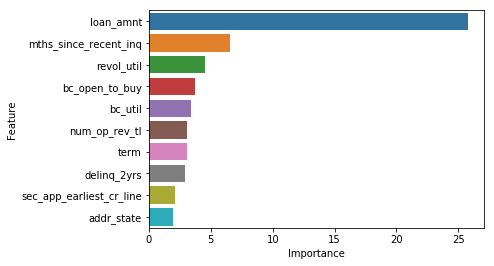

In [32]:
feat = model.feature_names_
imp = model.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df);

In gradient boosting the importances of highly correlated features usually split between them. From the correlation heatmap (see below) the feature `revol_util` (top 3) is quite highly correlated with `bc_util` (top 5) which leads to the decreased importance of `revol_util`.

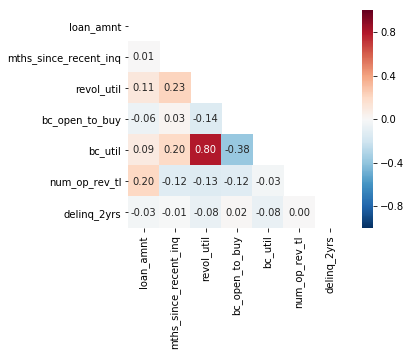

In [33]:
corr = X_mod[df['Feature'].values].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, square=True, cmap='RdBu_r', vmin=-1, vmax=1, annot=True, fmt='.2f');

It is also useful to look at the distributions of the features to see how their values influence predictions.

From the histogram for the feature `loan_amnt` (top 1) the loan is more likely to be returned (good loans) if the loan amount is lower. This makes sense because smaller loan amounts usually have smaller monthly installments that are easier to pay.

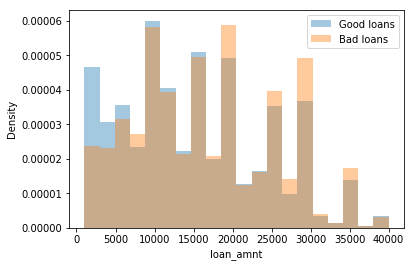

In [34]:
good = X_mod.loc[y_mod == 1, 'loan_amnt']
bad = X_mod.loc[y_mod == 0, 'loan_amnt']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

From the histogram for the feature `mths_since_recent_inq` (top 2) the loan is less likely to be returned (bad loans) if the borrower had an inquiry recently. This also makes sense because inquiries are usually done when someone applies for a loan, a credit card, etc. so recent inquiries could indicate bad financial stability of the borrower.

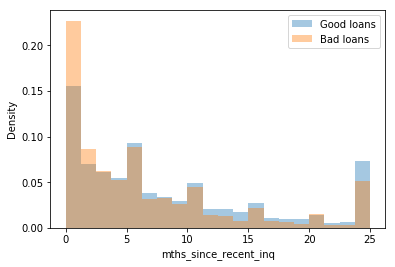

In [35]:
good = X_mod.loc[y_mod == 1, 'mths_since_recent_inq']
bad = X_mod.loc[y_mod == 0, 'mths_since_recent_inq']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

From the histogram for the feature `revol_util` (top 3) the loan is less likely to be returned (bad loans) if the revolving utilization is lower. This actually doesn't make much sense because revolving utilization is the percentage of the used credit on your credit card so higher revolving utilization indicates worse financial stability. Nevertheless, this dataset shows otherwise and it could be an interesting topic for discussion.

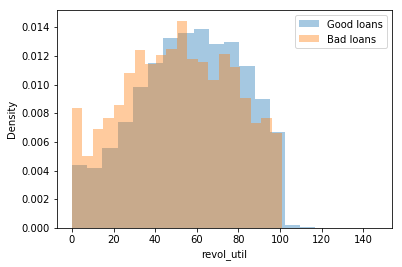

In [36]:
good = X_mod.loc[y_mod == 1, 'revol_util']
bad = X_mod.loc[y_mod == 0, 'revol_util']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

# 5. Model adjustment

The previously reported model was obtained by minimizing both false positive and false negative errors that contribute to precision and recall respectively. In reality, however, one of these errors might have a larger impact so it would be better to optimize for it instead. In case of loan investing, the false positive errors are the number of bad loans that were identified as good so the investor will loose money by investing in them. This is a direct loss and should be avoided. The false negative errors are the number of good loans that were identified as bad so the investor will not earn extra money by not investing in them. This is a missed opportunity and is less critical compared to the direct loss. Therefore, the false positive errors should be decreased (higher precision) even if the false negative errors will be increased (lower recall). The connection between precision and recall can be visualized using the precision-recall curve (see below). To calculate it, one requires probabilities of belonging to class 1 rather than the predicted labels. This precision-recall curve is calculated for the validation dataset because adjusting precision or recall is similar to adjusting hyperparameters. For each precision-recall pair the function `precision_recall_curve()` also returns the corresponding probability threshold. This threshold is the actual hyperparameter that will be used to obtain the best precision.

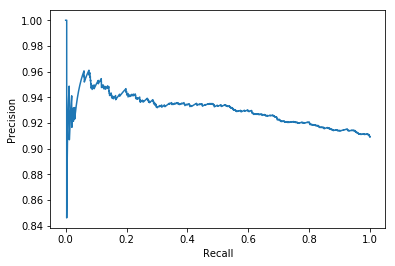

In [37]:
y_proba_val = model.predict_proba(pool_val)[:, 1]
p_val, r_val, t_val = precision_recall_curve(y_val, y_proba_val)
plt.plot(r_val, p_val)
plt.xlabel('Recall')
plt.ylabel('Precision');

From the precision-recall curve the best precision is 1 but then the recall would be extremely low so in the end the model might not predict good loans at all. Therefore, I exclude 1 from the precision array and find its maximum. The threshold array `t` returned by `precision_recall_curve()` is missing the threshold 0 in the beginning so I add it to match the dimension of the precision array `p`. Then I find the threshold that correspond to the maximum precision and recalculate the predicted labels. The obtained precision score for the adjusted labels is indeed the maximum (excluding 1) as can be seen from the precision-recall curve.

In [38]:
p_max = p_val[p_val != 1].max()
t_all = np.insert(t_val, 0, 0)
t_adj_val = t_all[p_val == p_max]
y_adj_val = (y_proba_val > t_adj_val).astype(int)
p_adj_val = precision_score(y_val, y_adj_val)
print(f'Adjusted precision (validation): {p_adj_val:.3f}')

Adjusted precision (validation): 0.961


Note that the above precision-recall curve is only valid for this particular validation dataset. So the precision that corresponds to the adjusted threshold on this dataset will be different from the precision for the same threshold on a different dataset. If these two datasets, however, are sampled from the same population, the precision values will have a certain spread that can be estimated using confidence intervals. Since precision is a proportion, it has the binomial distribution and its confidence interval can be conveniently calculated using the Statsmodels method `proportion_confint()`. Typically 95% confidence interval is calculated which corresponds to the parameter `alpha=0.05`. This means that the precision will be within this interval in 95% of cases. Since the obtained precision values are close to 1 (edge case), it's better to use the Wilson interval by setting the parameter `method='wilson'`. Also one should carefully calculate the denominator for adjusted precision `n` by taking the total amount of predicted good loans (class 1) after adjustment and not before.

In [39]:
n = y_adj_val.sum()
ci = proportion_confint(p_adj_val * n, n, alpha=0.05, method='wilson')
print(f'95% confidence interval for adjusted precision: [{ci[0]:.3f}, {ci[1]:.3f}]')

95% confidence interval for adjusted precision: [0.930, 0.979]


Finally by using the adjusted threshold on the testing dataset, the adjusted precision 0.939 is indeed within the above 95% confidence interval. Note, however, that the recall is significantly decreased from 0.632 to 0.068 but the precision only increased from 0.931 to 0.939. Of course the gain in precision depends on the train-test split and for a different testing dataset can be closer to the right boundary of the confidence interval. Getting higher values than that, however, is unlikely.

Adjusted precision (test): 0.939
Adjusted recall (test): 0.068


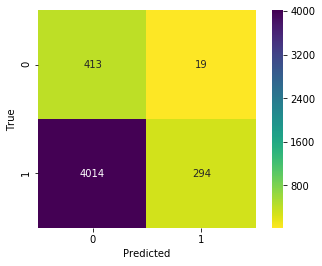

In [40]:
y_proba_test = model.predict_proba(pool_test)[:, 1]
y_adj_test = (y_proba_test > t_adj_val).astype(int)
p_adj_test = precision_score(y_test, y_adj_test)
r_adj_test = recall_score(y_test, y_adj_test)
print(f'''Adjusted precision (test): {p_adj_test:.3f}
Adjusted recall (test): {r_adj_test:.3f}''')

cm_test = confusion_matrix(y_test, y_adj_test)
ax = sns.heatmap(cm_test, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

Thanks for **UPVOTING** this kernel! Trying to become a Kernels Master. 🤘

Check out my other cool projects:
- [📊 Interactive Titanic dashboard using Bokeh](https://www.kaggle.com/pavlofesenko/interactive-titanic-dashboard-using-bokeh)
- [🌐 Extending Titanic dataset using Wikipedia](https://www.kaggle.com/pavlofesenko/extending-titanic-dataset-using-wikipedia)
- [👪 Titanic extended dataset (Kaggle + Wikipedia)](https://www.kaggle.com/pavlofesenko/titanic-extended)